<a href="https://colab.research.google.com/github/rajyash1904/BTP_PKB-2/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# New project

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import pandas as pd
tf.enable_eager_execution()

In [2]:
print(tf.__version__)
print(tf.test.is_gpu_available())

1.13.1
False


Set GPU/CPU

In [3]:
# OS.ENVIRON['CUDA_VISIBLE_DEVICES']="" #ONLY CPU

config = tf.ConfigProto()
#config = tf.compat.v1.ConfigProto
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
config.log_device_placement = True
#config.device_count={'gpu':0}
sess = tf.Session(config=config)

In [4]:
from process import preprocess

In [5]:
input_file = 'figs/longdress_vox10_1300.ply'
scale = 1
cube_size = 64
min_num = 64
res = 1024

In [6]:
cubes, cube_positions, points_numbers = preprocess(input_file, scale, cube_size, min_num)

==== Preprocess ====
Scaling: 0.0s
Partition: 59.4538s
Voxelisation: 30.9972s
Cubes shape: (202, 64, 64, 64, 1)
points numbers (sum/mean/max/min): 857600 4246 11450 78


point_numbers (min/max/mean): 78 11450 4245


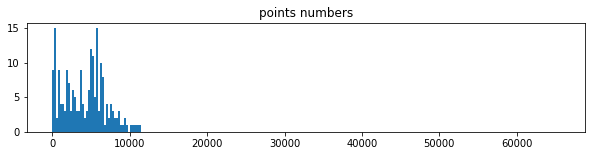

In [7]:
fig = plt.figure(figsize=(10,2))
print('point_numbers (min/max/mean):', points_numbers.min(), points_numbers.max(), int(points_numbers.mean()))
plt.title('points numbers')
n, bins, patches = plt.hist(points_numbers, bins=256, range=(1, pow(2,16)))
plt.show()


## Encoding

In [8]:
from transform import compress_factorized, decompress_factorized

In [9]:
import models.model_voxception as model
# import models.model_simple as model
ckpt_dir = "./checkpoints/factorized/a2b3/"

In [10]:
start = time.time()
strings, min_v, max_v, shape = compress_factorized(cubes, model, ckpt_dir)
print(time.time() - start)

===== Compress =====
Instructions for updating:
Colocations handled automatically by placer.
Analysis Transform: 1537.4046s
Entropy Encode: 3.7744s
1567.6526634693146


In [11]:
print(min_v.numpy(), max_v.numpy, shape.numpy())

-1 <bound method _EagerTensorBase.numpy of <tf.Tensor: id=60094, shape=(), dtype=int32, numpy=1>>[202  16  16  16  16]


## Write Files

In [14]:
from dataprocess.inout_bitstream import write_binary_files_factorized
filename = os.path.split(input_file)[-1][:-4]
rootdir = './compressed/'
print(rootdir, filename)
bytes_strings, bytes_pointnums, bytes_cubepos = write_binary_files_factorized(filename, strings.numpy(), points_numbers, cube_positions, min_v.numpy(), max_v.numpy(), shape.numpy(), rootdir)

./compressed/ longdress_vox10_1300
===== Write binary files =====
Total file size (Bytes): 2618286
Strings (Bytes): 2617792
Numbers of points (Bytes): 404
Positions of cubes (Bytes): 90


In [16]:
import subprocess
subp = subprocess.Popen("ls ./compressed/", shell=True, stdout=subprocess.PIPE)
c = subp.stdout.readline()
while c:
    print(c)
    c = subp.stdout.readline()

b'longdress_vox10_1300.cubepos\n'
b'longdress_vox10_1300_cubepos.ply\n'
b'longdress_vox10_1300.pointnums\n'
b'longdress_vox10_1300.strings\n'


# Decompress

### Read Files

In [18]:
from dataprocess.inout_bitstream import read_binary_files_factorized
strings_d, points_numbers_d, cube_positions_d, min_v_d, max_v_d, shape_d = read_binary_files_factorized(filename, rootdir)

===== Read binary files =====


### Decoding

In [19]:
from transform import decompress_factorized
cube_d = decompress_factorized(strings_d, min_v_d, max_v_d, shape_d, model, ckpt_dir)

===== Decompress =====
Entropy Decode: 1.5874s
Synthesis Transform: 1078.4483s


### Post Process

In [22]:
from process import postprocess
rho = 1.0
output_file = filename + "_rec.ply"
postprocess(output_file, cube_d.numpy(), points_numbers_d, cube_positions_d, scale, cube_size, rho)

# Metrics

### bpp

In [23]:
def get_points_number(filedir):
    plyfile = open(filedir)
    line = plyfile.readline()
    while line.find("element vertex") == -1:
        line = plyfile.readline()
    number = int(line.split(' ')[-1][:-1])
    return number    

In [24]:
N = get_points_number(input_file)
print(N)

857966


In [25]:
print("bpp: ", round(8*(bytes_strings + bytes_pointnums + bytes_cubepos)/float(N), 4))
print("strings: ", round(8*bytes_strings/float(N),4), "points numbers: ", round(8*bytes_pointnums/float(N),4), "cubes positions: ", round(8*bytes_cubepos/float(N),4))

bpp:  24.4139
strings:  24.4093 points numbers:  0.0038 cubes positions:  0.0008


## pc_error

In [26]:
import subprocess

subp=subprocess.Popen("myutils/pc_error_d" 
                      + ' -a ' + input_file
                      + ' -b ' + output_file
                      +' -n ' + input_file 
                      + ' --hausdorff=1 '
                      + " -r "+str(res-1), 
                      shell=True, stdout=subprocess.PIPE)

c=subp.stdout.readline()
while c:
    print(c)
    c=subp.stdout.readline()

print(subp.returncode)

b'PCC quality measurement software, version 0.13.4\n'
b'\n'
b'infile1:        figs/longdress_vox10_1300.ply\n'
b'infile2:        longdress_vox10_1300_rec.ply\n'
b'normal1:        figs/longdress_vox10_1300.ply\n'
b'singlePass:     0\n'
b'hausdorff:      1\n'
b'color:          0\n'
b'lidar:          0\n'
b'resolution:     1023\n'
b'dropDuplicates: 2\n'
b'neighborsProc:  1\n'
b'averageNormals: 1\n'
b'nbThreads:      1\n'
b'\n'
b'Verifying if the data is loaded correctly.. The last point is: 256 902 320\n'
b'Reading file 1 done.\n'
b'Error reading normal reference point cloud:figs/longdress_vox10_1300.ply\n'
None


In [27]:
import open3d as o3d
pcd = o3d.io.read_point_cloud(input_file)

In [28]:
o3d.visualization.draw_geometries([pcd])

In [30]:
pcd_rec = o3d.io.read_point_cloud(output_file)
o3d.visualization.draw_geometries([pcd_rec])

[Open3D WARNING] Read PLY failed: unable to open file: longdress_vox10_1300_rec.ply
